In [1]:
# Import Mask RCNN and load my weights of my trained model
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from mrcnn import visualize
import mrcnn.model as modellib
import nucleus
import tensorflow as tf
from scipy.io import savemat

config = nucleus.NucleusInferenceConfig()
config.display()
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
with tf.device(DEVICE):
    nmodel = modellib.MaskRCNN(mode="inference",
                              model_dir=os.getcwd(),
                              config=config)
weights_path = "/Users/akre96/Data/BE_223B/mask_rcnn_weights.h5"
nmodel.load_weights(weights_path, by_name=True)  

/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [9]:
import progressbar
import pandas as pd
tile_path = '/Users/akre96/Data/BE_223B/tiles_rois/normalized/'
centroid_path = '/Users/akre96/Data/BE_223B/tiles_rois/centroids/'
mask_path = '/Users/akre96/Data/BE_223B/tiles_rois/masks/'

tile_files = os.listdir(tile_path)
tile_file_paths = [os.path.join(tile_path, tf) for tf in tile_files if tf[0] != '.']

for tile_file in progressbar.progressbar(tile_file_paths):
    ys = []
    xs = []
    tile_id = tile_file.split('/')[-1].split('.')[0]
    out_path = os.path.join(
            centroid_path,
            tile_id + '.csv',
    )
    mask_out_path = os.path.join(
            mask_path,
            tile_id + '.csv',
    )
    if os.path.exists(out_path) and os.path.exists(mask_out_path):
        continue
    
    tile = skimage.io.imread(tile_file)
    scaled_tile = skimage.transform.rescale(tile, 2, multichannel=True) * 255
    patch_size = scaled_tile.shape[0]
    results = nmodel.detect([scaled_tile], verbose=0)
    r = results[0]
    individual_nuclei = r['masks']
    mask_dfs = []
    for i in range(individual_nuclei.shape[2]):

        descale_mask = skimage.transform.rescale(individual_nuclei[:,:,i], 0.5)
        y, x = np.where(descale_mask)
        y_mean, x_mean = np.mean((y, x), axis=1)
        mask_dict = {
            'tile': tile_id,
            'mask_id': i,
            'x': x,
            'y': y,
        }
        mask_dfs.append(pd.DataFrame.from_dict(mask_dict))
        ys.append(y_mean)
        xs.append(x_mean)
    pd.concat(mask_dfs).to_csv(mask_out_path, index=False)
    centroid_df = pd.DataFrame.from_dict(
        {
            'x': xs,
            'y': ys
        }
    )

    centroid_df.to_csv(
        out_path,
        index=False,
    )


1% (13 of 1000) |                      | Elapsed Time: 0:08:00 ETA:  11:01:13/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
100% (1000 of 1000) |###################| Elapsed Time: 10:50:44 Time: 10:50:44


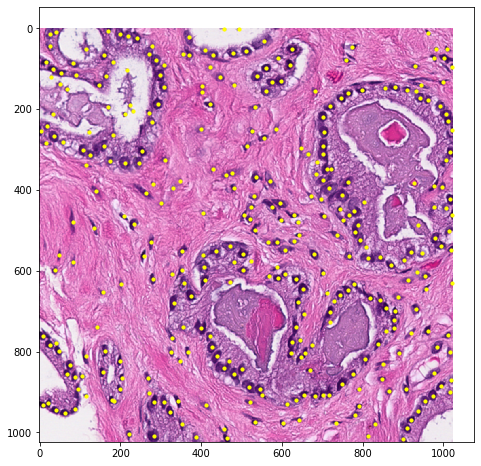

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(scaled_tile/255)
ax.scatter(xs,ys, c='yellow', s=10)

In [56]:
tile_file.split('.')[0] + '.csv'

'/Users/akre96/Data/BE_223B/tiles_rois/normalized/7664_26880_36736.csv'